In [ ]:
!pip install mediapipe

In [ ]:
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Bidirectional, Dropout

In [ ]:
import os
import cv2
import numpy as np
import mediapipe as mp
import time

# Key Points Extraction


In [ ]:
mp_holistic = mp.solutions.holistic
holistic = mp_holistic.Holistic()

def extract_keypoints(frame):
    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = holistic.process(rgb_frame)

    keypoints = []
    if results.pose_landmarks:
        for landmark in results.pose_landmarks.landmark:
            keypoints.append([landmark.x, landmark.y, landmark.z])
    else:
        return None

    return np.array(keypoints)

In [ ]:
def normalize_single_frame_keypoints(keypoints):
    min_val = np.min(keypoints, axis=0)
    max_val = np.max(keypoints, axis=0)

    scale = np.where(max_val - min_val == 0, 1, max_val - min_val)

    normalized_keypoints = (keypoints - min_val) / scale

    return normalized_keypoints

In [ ]:
def create_sequences_with_keypoints(video_path, folder_name, sequence_length):
    cap = cv2.VideoCapture(video_path)

    fps = cap.get(cv2.CAP_PROP_FPS)
    frame_skip_interval = int(round(fps / 15))

    keypoints_list = []
    frame_count = 0
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        if frame_count % frame_skip_interval == 0:
          keypoints = extract_keypoints(frame)
          if keypoints is None:
            continue
          normalized_keypoints = normalize_single_frame_keypoints(keypoints)
          keypoints_list.append(normalized_keypoints.flatten())
        frame_count += 1

    cap.release()

    X_sequences = []
    y_labels = []
    for i in range(len(keypoints_list) - sequence_length + 1):
        sequence = keypoints_list[i:i + sequence_length]
        X_sequences.append(sequence)
        y_labels.append(np.array([folder_name]))

    return np.array(X_sequences), np.array(y_labels)

In [ ]:
%%time
path = '/content/drive/MyDrive/KTH/All Videos'

x_sequences = []
y_sequences = []
num = 0

for class_folder in os.listdir(path):
    video_path = os.path.join(path, class_folder)

    for filename in os.listdir(video_path):
        video = os.path.join(video_path, filename)
        num += 1
        print(f'Video {num}/600')
        X_add, y_add = create_sequences_with_keypoints(video, class_folder, 15, pose)
        x_sequences.extend(X_add)
        y_sequences.extend(y_add)

save_path_x = '/content/drive/MyDrive/KTH/x_sequences_connections.npy'
save_path_y = '/content/drive/MyDrive/KTH/y_sequences_connections.npy'

np.save(save_path_x, x_sequences)
np.save(save_path_y, y_sequences)

# Frame Extraction (without MediaPipe)

In [ ]:
mp_holistic = mp.solutions.holistic
holistic = mp_holistic.Holistic()

def have_keypoints(frame):
    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = holistic.process(rgb_frame)

    if results.pose_landmarks:
      return True
    else:
      return False

In [ ]:
def create_sequences(video_path, folder_name, sequence_length):
    cap = cv2.VideoCapture(video_path)

    fps = cap.get(cv2.CAP_PROP_FPS)
    frame_skip_interval = int(round(fps / 15))

    frames_list = []
    frame_count = 0
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        if frame_count % frame_skip_interval == 0:
          # keypoints = have_keypoints(frame)
          # if keypoints is True:
          #   continue
          normalized_keypoints = frame.astype('float32') / 255.0
          frames_list.append(normalized_keypoints.flatten())
        frame_count += 1

    cap.release()

    X_sequences = []
    y_labels = []
    for i in range(len(frames_list) - sequence_length + 1):
        sequence = frames_list[i:i + sequence_length]
        X_sequences.append(sequence)
        y_labels.append(np.array([folder_name]))

    return np.array(X_sequences), np.array(y_labels)

In [ ]:
path = '/content/drive/MyDrive/KTH/All Videos'

x_sequences = []
y_sequences = []
num = 0

for class_folder in os.listdir(path):
    video_path = os.path.join(path, class_folder)

    for filename in os.listdir(video_path):
        video = os.path.join(video_path, filename)
        num += 1
        print(f'Video {num}/600')
        X_add, y_add = create_sequences(video, class_folder, 15)
        x_sequences.extend(X_add)
        y_sequences.extend(y_add)

save_path_x = '/content/drive/MyDrive/KTH/x_sequences_frames.npy'
save_path_y = '/content/drive/MyDrive/KTH/y_sequences_frames.npy'

np.save(save_path_x, x_sequences)
np.save(save_path_y, y_sequences)

Video 1/600
Video 2/600
Video 3/600


# Preprocess

In [ ]:
x_sequences = np.load("/content/drive/MyDrive/KTH/x_sequences_no0.npy")
y_sequences = np.load('/content/drive/MyDrive/KTH/y_sequences_no0.npy')

In [ ]:
x_sequences.shape[0]

89755

In [ ]:
y_sequences_flat = np.concatenate(y_sequences)

In [ ]:
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(y_sequences_flat)
onehot_encoded = to_categorical(integer_encoded)

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    np.array(x_sequences), onehot_encoded, test_size=0.2, random_state=42
)

In [ ]:
x_sequences = 0
y_sequences = 0

# Transformer Encoder

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.layers import Dense, Input, GlobalAveragePooling1D, Dropout, BatchNormalization, Activation

class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_size, output_dim, **kwargs):
        super(PositionalEmbedding, self).__init__(**kwargs)
        self.pos_emb = layers.Embedding(input_dim=sequence_size, output_dim=output_dim)

    def call(self, x):
        length = tf.shape(x)[1]
        positions = tf.range(start=0, limit=length, delta=1)
        positions = self.pos_emb(positions)
        return x + positions

class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerEncoder, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training=False):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)

        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

def build_vit_classifier(num_patches, embed_dim, num_heads, ff_dim, num_layers, num_classes):
    inputs = tf.keras.Input(shape=(num_patches, embed_dim))
    x = inputs

    for _ in range(num_layers):
      x = PositionalEmbedding(num_patches, embed_dim)(inputs)
      x = TransformerEncoder(embed_dim, num_heads, ff_dim)(x)

    x = GlobalAveragePooling1D()(x)
    outputs = Dense(num_classes, activation="softmax")(x)
    return tf.keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
num_patches = 15
embed_dim = 99
num_heads = 12
ff_dim = 300
num_classes = 6
num_layers = 4

model = build_vit_classifier(num_patches, embed_dim, num_heads, ff_dim, num_layers, num_classes)
optimizer = tf.keras.optimizers.RMSprop(learning_rate=1e-5)
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

In [ ]:
history = model.fit(X_train, y_train, validation_split=0.1, batch_size=64, epochs=50)

Epoch 1/50
1010/1010 [==============================] - 14s 10ms/step - loss: 0.6514 - accuracy: 0.7955 - val_loss: 0.3173 - val_accuracy: 0.9006
Epoch 2/50
1010/1010 [==============================] - 10s 10ms/step - loss: 0.2822 - accuracy: 0.9061 - val_loss: 0.2116 - val_accuracy: 0.9227
Epoch 3/50
1010/1010 [==============================] - 10s 10ms/step - loss: 0.2104 - accuracy: 0.9235 - val_loss: 0.1702 - val_accuracy: 0.9371
Epoch 4/50
1010/1010 [==============================] - 9s 9ms/step - loss: 0.1783 - accuracy: 0.9327 - val_loss: 0.1493 - val_accuracy: 0.9421
Epoch 5/50
1010/1010 [==============================] - 10s 10ms/step - loss: 0.1594 - accuracy: 0.9395 - val_loss: 0.1362 - val_accuracy: 0.9474
Epoch 6/50
1010/1010 [==============================] - 10s 10ms/step - loss: 0.1462 - accuracy: 0.9440 - val_loss: 0.1266 - val_accuracy: 0.9501
Epoch 7/50
1010/1010 [==============================] - 10s 10ms/step - loss: 0.1363 - accuracy: 0.9479 - val_loss: 0.1186 - v

In [ ]:
model.save('/content/drive/MyDrive/KTH/Models/TransformerEncoder_0.001_75', save_format='tf')

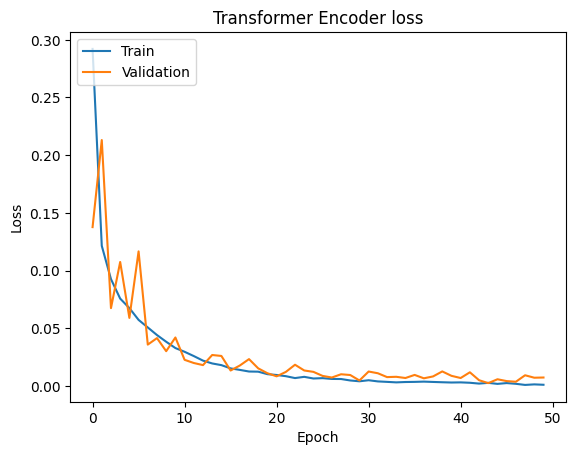

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Transformer Encoder loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
model.evaluate(X_test, y_test)

561/561 [==============================] - 3s 5ms/step - loss: 7.1987e-04 - accuracy: 0.9998


[0.0007198722450993955, 0.9997771978378296]

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

predictions = model.predict(X_test)
predicted_classes = np.argmax(predictions, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

accuracy = accuracy_score(y_test_classes, predicted_classes)
precision = precision_score(y_test_classes, predicted_classes, average='macro')
recall = recall_score(y_test_classes, predicted_classes, average='macro')
f1 = f1_score(y_test_classes, predicted_classes, average='macro')

print(f"Accuracy: {accuracy * 100:.3f}%")
print(f"Precision: {precision * 100:.3f}%")
print(f"Recall: {recall * 100:.3f}%")
print(f"F1 Score: {f1 * 100:.3f}%")

561/561 [==============================] - 3s 6ms/step
Accuracy: 99.978%
Precision: 99.954%
Recall: 99.944%
F1 Score: 99.949%


561/561 [==============================] - 2s 4ms/step
[[4131    0    1    0    0    0]
 [   0 3919    0    0    0    0]
 [   0    0 5078    0    0    0]
 [   0    0    0 1486    0    0]
 [   0    0    0    3  811    0]
 [   0    0    0    0    0 2522]]


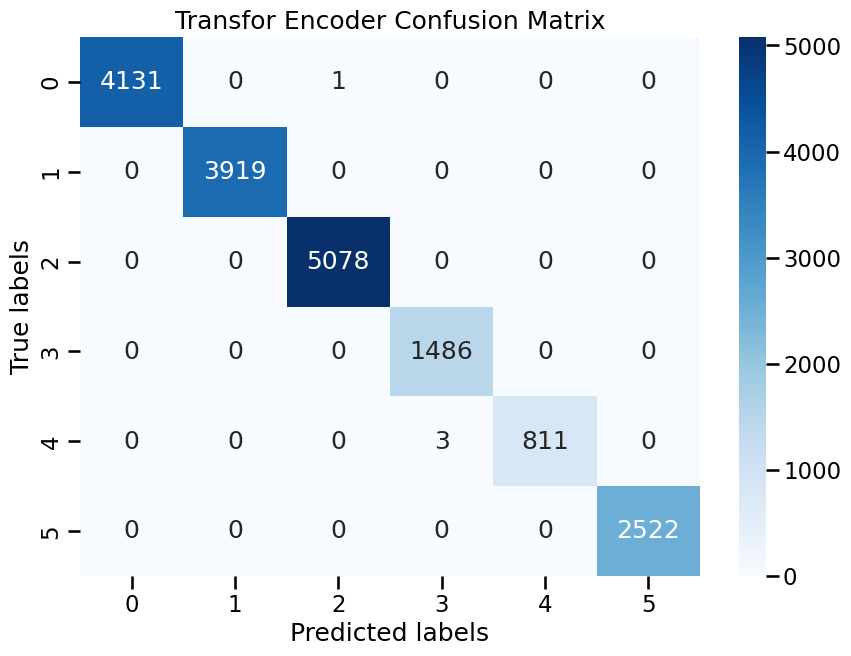

In [ ]:
predictions = model.predict(X_test)
predicted_classes = np.argmax(predictions, axis=1)

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


if len(y_test.shape) > 1 and y_test.shape[1] > 1:
    true_classes = np.argmax(y_test, axis=1)
else:
    true_classes = y_test


cm = confusion_matrix(true_classes, predicted_classes)

print(cm)

plt.figure(figsize=(10, 7))
sns.set_context("talk")
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Transfor Encoder Confusion Matrix')
plt.show()